Data source: 
https://www.kaggle.com/rmisra/news-category-dataset/data#

In [1]:
import pandas as pd
import numpy as np

from textblob import TextBlob  # for sentiment analysis
import spacy 
# python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances


import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", color_codes=True)
%matplotlib inline

## Import data

In [7]:
df = pd.read_json('data/News_Category_Dataset_v2.json', lines=True)

### Explore data

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200853 non-null  object        
 1   headline           200853 non-null  object        
 2   authors            200853 non-null  object        
 3   link               200853 non-null  object        
 4   short_description  200853 non-null  object        
 5   date               200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.2+ MB


In [9]:
df.describe()

,category,headline,authors,link,short_description,date
count,200853,200853,200853,200853,200853,200853
unique,41,199344,27993,200812,178353,2309
top,POLITICS,Sunday Roundup,,https://www.huffingtonpost.comhttp://www.newre...,,2013-01-17 00:00:00
freq,32739,90,36620,2,19712,100
first,NaN,NaN,NaN,NaN,NaN,2012-01-28 00:00:00
last,NaN,NaN,NaN,NaN,NaN,2018-05-26 00:00:00


#### Initial thoughts on questions I can ask (graphs I can make)
* How do articles break down over categories?
* Does sentiment within different categories change over time?
* Do different authors have biases in tone? 
    * Are those tone biases category-specific?
* Does the sentiment "extremeness" of the headline correlate to the sentiment "extremeness" of the description?
* How many different authors does HuffPost have?
    * Do any of them write for multiple categories?
    * How much turnover do those authors have?


#### What actionable insights can I pull from this? 
What can this teach me about how to read the news?

* If you read HuffPost, which authors tend to the most biased?
* If you read HuffPost, which topics tend to be the most biased?
* If you read HuffPost and want to feel cheered up, what authors and topics should you read?
* What topics tend to have deceptive headlines that lead to articles that are very subjective or polarizing?

## Transform data

### Add sentiment analysis

In [11]:
def get_sentiment(article):
    try:
        return TextBlob(article).sentiment
    except:
        return None

In [ ]:
df['pol_sub_hl'] = df.headline.apply(get_sentiment)
df['pol_hl'] = df.pol_sub_hl.apply(lambda x: x[0])
df['subj_hl'] = df.pol_sub_hl.apply(lambda x: x[1])

#FUTURE: optimize this so not traversing entire df 3x


In [12]:
df['pol_sub_desc'] = df.short_description.apply(get_sentiment)
df['pol_desc'] = df.pol_sub_desc.apply(lambda x: x[0])
df['subj_desc'] = df.pol_sub_desc.apply(lambda x: x[1])

In [15]:
# save out df so I don't have to recalculate (too many rows)
# df.to_csv('data/huff_post_with_senti.csv')

## Import data (sentiments calculated)

In [ ]:
# df = pd.read_csv('data/huff_post_with_senti.csv')

## Analyze & visualize data

### See sentiment of descriptions by category

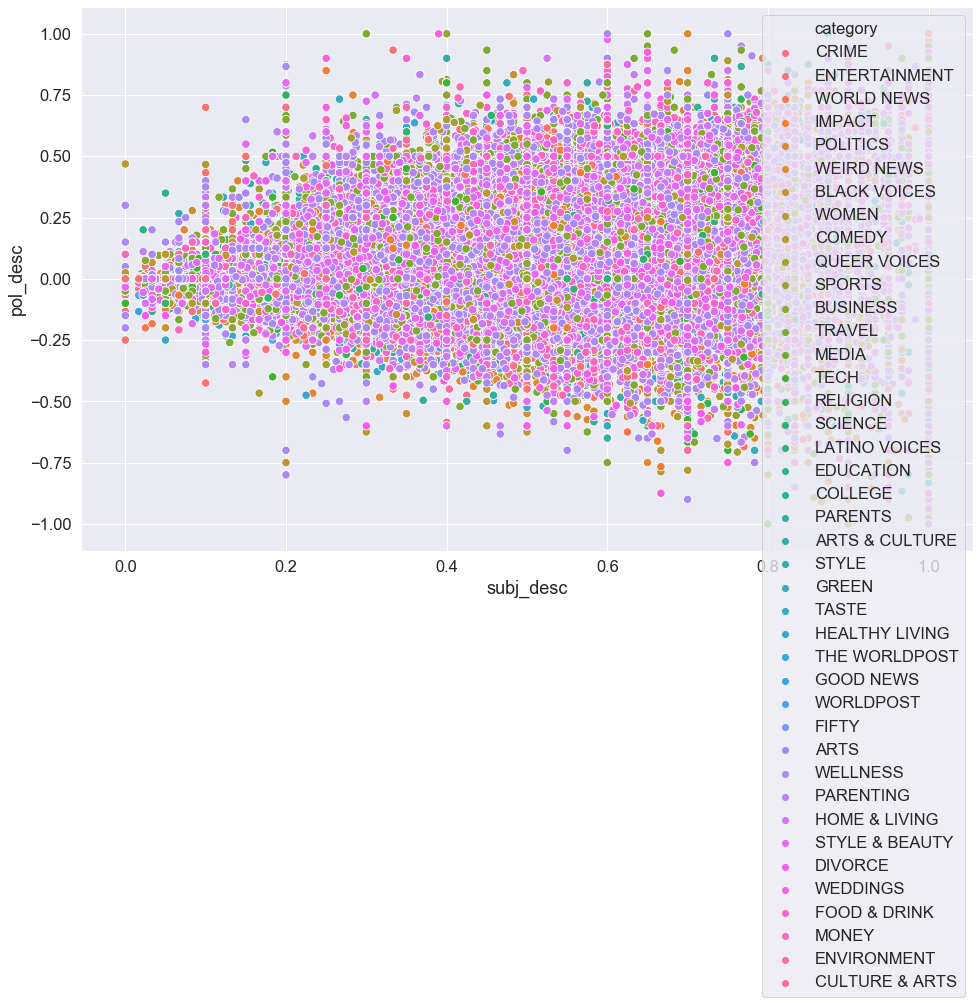

In [17]:
plt.figure(figsize=(16, 10))
sns.set(font_scale=1.5)
ax = sns.scatterplot(x='subj_desc', y="pol_desc", hue="category", s=70,
                     data=df)


Lots of categories (too many). Which ones to cut out?

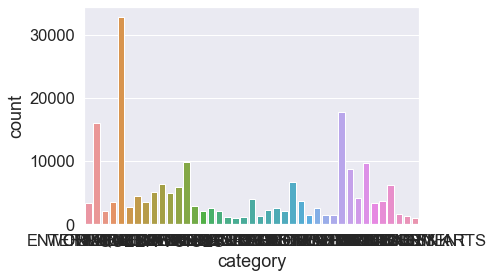

In [21]:
ax = sns.countplot(x="category", data=df)

# another interesting thing to try:
# ax = sns.countplot(x="category", hue="author", data=df)


Based on the visual, we'll take the top 6 groups (arbitrary)

In [34]:
categ_to_keep = df['category'].value_counts().head(6).index.values.tolist()

# CHECK / CHECKSUM
print(categ_to_keep)
print(len(categ_to_keep))

['POLITICS', 'WELLNESS', 'ENTERTAINMENT', 'TRAVEL', 'STYLE & BEAUTY', 'PARENTING']
6


In [35]:
# Subset df to the 6 categories we care about
df_6_categ = df[df['category'].isin(categ_to_keep)]

In [44]:
# CHECK
print('Length before: {} | Length after: {}'.format(df.shape[0],df_6_categ.shape[0]))

perc = (df.shape[0] - df_6_categ.shape[0]) / df.shape[0] * 100
print('% of values cut out: {}%'.format(round(perc)))     

Length before: 200853 | Length after: 94837
% of values cut out: 53%


### (Top 6 categ) See sentiment of descriptions by category

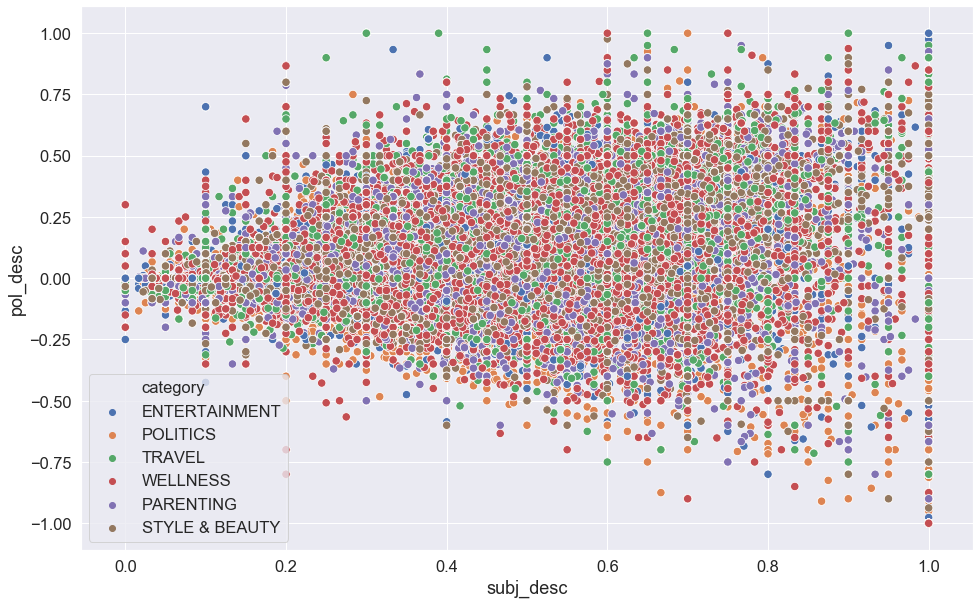

In [45]:
# Try graph again
plt.figure(figsize=(16, 10))
sns.set(font_scale=1.5)
ax = sns.scatterplot(x='subj_desc', y="pol_desc", hue="category", s=70,
                     data=df_6_categ)


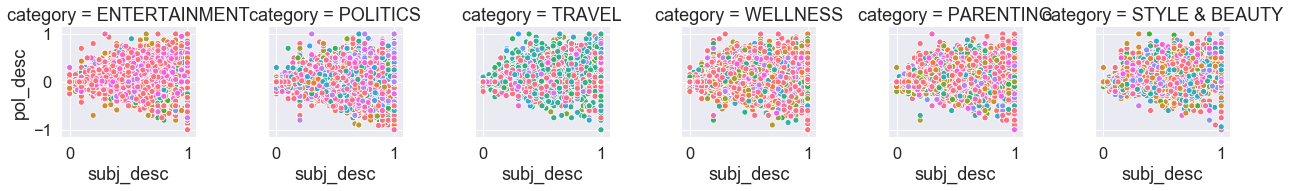

In [49]:
# Maybe if you graph it individually?
g = sns.FacetGrid(df_6_categ, col='category')
g.map(sns.scatterplot, 'subj_desc', 'pol_desc', 'authors')